<a href="https://colab.research.google.com/github/kelianmaya/Tugas_DL/blob/main/Tugas_DL/TugasDLTM4/running_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'nnfl-cnn-lab2:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F19704%2F1064412%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240501%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240501T081241Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D7880a1e58dc9b35d6d408ac0f0e4e4d1ba12da86c63590193e973a761806cd589c2090be5a45a7d5886010b336b8f30285f3d201fa26a0f4f9661fbf0fdb75fb5474ccab8e7208db8bf2ad514445c6d643cc2680f7a141b931624eadd1d3756e23fc001ef9dac42aef2db0791b2f2c8ee13515609c79c4b468802b48e3a41c0beae26c6fb21d2729c182ae14b225350cc83f1e02198af907bb59597234c4e68e67373709202466e66da037c66a6d2c90b2b945093181addd30e5c544b1ac9597ab2fd348f371a23b0170290c8b5f9929ec7ad2cdcff33c3e2de530cf1f09ec60930af7f820b220720b3d1c19fe8c819447bae31d90abacf7ee66b5d9a073d1d3'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 318864853 bytes downloaded
Downloaded and uncompressed: nnfl-cnn-lab2
Data source import complete.


In [ ]:
import os

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from keras.layers import Input
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from PIL import Image

from keras.models import Sequential,Model
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint
from keras.optimizers import RMSprop
from keras.initializers import glorot_uniform

In [ ]:
df = pd.read_csv('/kaggle/input/nnfl-cnn-lab2/upload/train_set.csv')

In [ ]:
df.head()

,image_name,label
0,0.jpg,0
1,1.jpg,4
2,2.jpg,5
3,4.jpg,0
4,7.jpg,4


In [ ]:
df['label'] = df['label'].astype(str)
df.dtypes

image_name    object
label         object
dtype: object

<Axes: xlabel='label'>

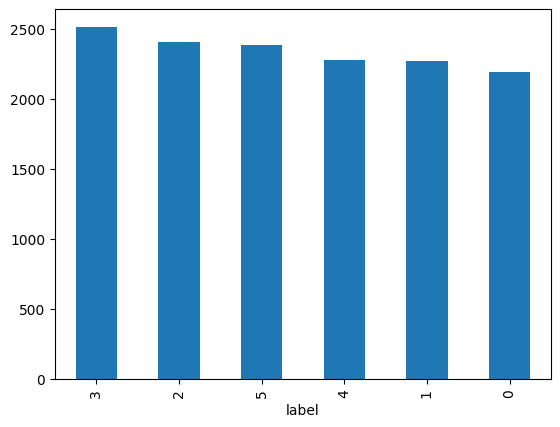

In [ ]:
df['label'].value_counts().plot.bar()

(150, 150)


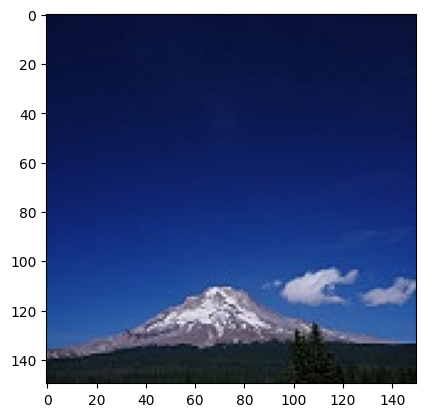

In [ ]:
filenames = os.listdir('/kaggle/input/nnfl-cnn-lab2/upload/train_images/train_images/')
sample = random.choice(filenames)
image = load_img('/kaggle/input/nnfl-cnn-lab2/upload/train_images/train_images/'+sample)
plt.imshow(image)
print(image.size)

In [ ]:
IMAGE_HEIGHT = 150
IMAGE_WIDTH = 150
IMAGE_CHANNELS = 3
IMAGE_SIZE = (IMAGE_HEIGHT,IMAGE_WIDTH)
batch_size = 15

In [ ]:
def identity_block(X, f, filters, stage, block):

    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value. You'll need this later to add back to the main path.
    X_shortcut = X

    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = Activation('relu')(X)
    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = Activation('relu')(X)
    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)


    return X
def convolutional_block(X, f, filters, stage, block, s = 2):

    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = Activation('relu')(X)
    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = Activation('relu')(X)
    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)

    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(filters = F3, kernel_size = (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    return X

def ResNet50(input_shape=(64, 64, 3), classes=6):

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)

    X = Conv2D(128, (3, 3), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)
    X = convolutional_block(X, f=3, filters=[128, 128, 51], stage=2, block='a', s=1)
    X = AveragePooling2D((2,2), name="avg_pool")(X)

    ### END CODE HERE ###

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)


    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model
model = ResNet50(input_shape = (150, 150, 3), classes = 6)
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 156, 156, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1 (Conv2D)              (None, 77, 77, 128)          3584      ['zero_padding2d[0][0]']      
                                                                                                  
 activation (Activation)     (None, 77, 77, 128)          0         ['conv1[0][0]']        

In [ ]:
earlystop = EarlyStopping(patience=60)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=2,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)
Checkpoint = ModelCheckpoint('temp.h5', monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', period=1)
callbacks = [earlystop, learning_rate_reduction,Checkpoint]

In [ ]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

<Axes: xlabel='label'>

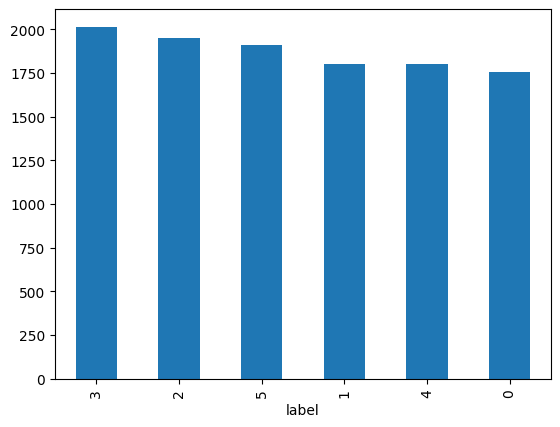

In [ ]:
train_df['label'].value_counts().plot.bar()

<Axes: xlabel='label'>

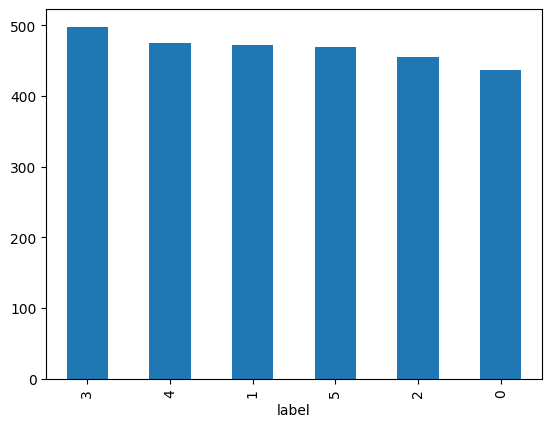

In [ ]:
validate_df['label'].value_counts().plot.bar()

In [ ]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
print(total_train, total_validate)

11227 2807


In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    "/kaggle/input/nnfl-cnn-lab2/upload/train_images/train_images/",
    x_col='image_name',
    y_col='label',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 11227 validated image filenames belonging to 6 classes.


In [ ]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    "/kaggle/input/nnfl-cnn-lab2/upload/train_images/train_images/",
    x_col='image_name',
    y_col='label',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 2807 validated image filenames belonging to 6 classes.


In [ ]:
epochs = 20

# Assuming you have defined train_generator and validation_generator correctly
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate // batch_size,
    steps_per_epoch=total_train // batch_size,
    callbacks=callbacks
)


Epoch 1/20
748/748 [==============================] - ETA: 0s - loss: 1.1226 - accuracy: 0.5712
Epoch 1: val_accuracy improved from -inf to 0.68093, saving model to temp.h5
748/748 [==============================] - 659s 879ms/step - loss: 1.1226 - accuracy: 0.5712 - val_loss: 0.8833 - val_accuracy: 0.6809 - lr: 0.0010
Epoch 2/20
748/748 [==============================] - ETA: 0s - loss: 0.8534 - accuracy: 0.6875
Epoch 2: val_accuracy improved from 0.68093 to 0.76613, saving model to temp.h5
748/748 [==============================] - 624s 834ms/step - loss: 0.8534 - accuracy: 0.6875 - val_loss: 0.6645 - val_accuracy: 0.7661 - lr: 0.0010
Epoch 3/20
748/748 [==============================] - ETA: 0s - loss: 0.7556 - accuracy: 0.7220
Epoch 3: val_accuracy did not improve from 0.76613
748/748 [==============================] - 619s 828ms/step - loss: 0.7556 - accuracy: 0.7220 - val_loss: 0.7178 - val_accuracy: 0.7497 - lr: 0.0010
Epoch 4/20
748/748 [==============================] - ETA: 0

In [ ]:
model.load_weights('temp.h5')

In [ ]:
model.save_weights("model.h5")

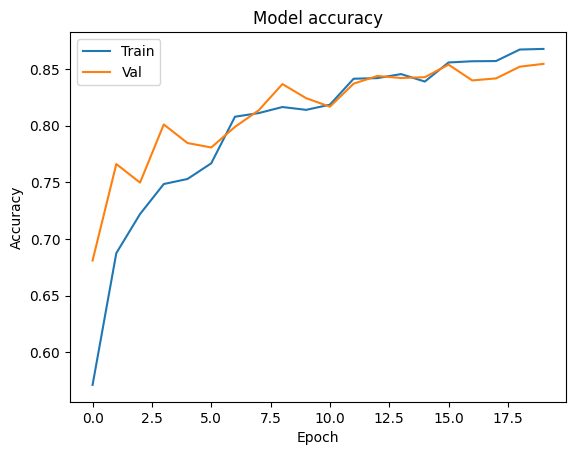

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()


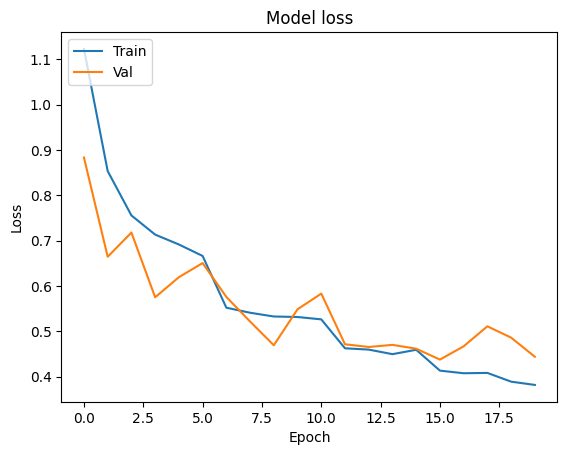

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [ ]:
validation_generator = validation_datagen.flow_from_dataframe(
    pd.DataFrame(validate_df),
    "/kaggle/input/nnfl-cnn-lab2/upload/train_images/train_images/",
    x_col='image_name',
    y_col='label',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle = False
)
y_pred = [np.argmax(a) for a in (model.predict_generator(validation_generator))]

Found 2807 validated image filenames belonging to 6 classes.


<ipython-input-24-d37e3074760d>:11: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = [np.argmax(a) for a in (model.predict_generator(validation_generator))]


In [ ]:
f1_score(y_pred,validate_df['label'].astype(int), average = 'micro')

In [ ]:
confusion_matrix(y_pred,validate_df['label'].astype(int))

In [ ]:
test_df = pd.read_csv('/kaggle/input/nnfl-cnn-lab2/upload/sample_submission.csv')

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    test_df,
    "/kaggle/input/nnfl-cnn-lab2/upload/test_images/test_images/",
    x_col='image_name',
    y_col=None,
    target_size=IMAGE_SIZE,
    class_mode=None,
    batch_size=batch_size,
    shuffle = False
)
nb_samples = test_df.shape[0]

In [ ]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

In [ ]:
test_df['label'] = np.argmax(predict, axis = -1)

In [ ]:
test_df.head()

,image_name,label
0,3.jpg,5
1,5.jpg,0
2,6.jpg,4
3,11.jpg,4
4,14.jpg,5


In [ ]:
test_df['label'].value_counts().plot.bar()

In [ ]:
submission_df = test_df.copy()
submission_df['image_name'] = submission_df['image_name']
submission_df['label'] = submission_df['label']
submission_df.image_name = submission_df.image_name.apply(str)
#submission_df.drop(['filename', 'category'], axis=1, inplace=True)
print(submission_df.head())
submission_df.to_csv('submission.csv', index=False)

In [ ]:
from IPython.display import HTML
import pandas as pd
import numpy as np
import base64
def create_download_link(df, title = "Download CSV file", filename = "data.csv"):
    csv = df.to_csv(index=False)
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)
create_download_link(submission_df)